## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.

In [2]:
from IPython import get_ipython
from typing_extensions import Annotated

import autogen

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-1106-preview"], 
    },
)

user_proxy (to chatbot):

Draw two agents chatting with each other with an example dialog. Don't add plt.show().

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested tool Call (call_yZrbWbvogzcxiHsQpv0sj66C): python *****
Arguments: 
cell = """
import matplotlib.pyplot as plt

# Define the figure and subplots
fig, ax = plt.subplots(figsize=(8, 5))

# Draw two agents as circles
ax.plot(1, 2, 'o', ms=20, label='Agent 1')
ax.plot(3, 2, 'o', ms=20, label='Agent 2')

# Draw dialog balloons for each agent
ax.annotate("Hello! How are you?", xy=(1, 2), xytext=(0.5, 2.5),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
ax.annotate("I'm fine, thanks!", xy=(3, 2), xytext=(3.5, 2.5),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

# Remove axis and set limits
ax.axis('off')
ax.set_xlim(0, 4)
ax.set_ylim(1, 3)

# Add labels for agents
ax.legend(loc='upper center')

"""

# Exec

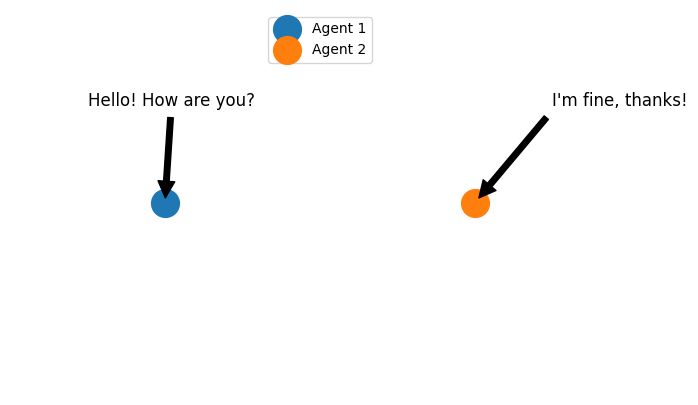

user_proxy (to chatbot):

user_proxy (to chatbot):

***** Response from calling tool "call_CVadmN6W76hIkVJIUYhzJ6dF" *****
Legend
**********************************************************************

--------------------------------------------------------------------------------
chatbot (to user_proxy):

The drawing of the two agents chatting with each other and their example dialog has been generated, but without displaying the plot as you requested. Here's a description of what was done:

- Two circular agents were created and placed at coordinates (1, 2) and (3, 2) on the plot.
- Dialog balloons were added to represent their conversation, with agent 1 saying "Hello! How are you?" and agent 2 replying with "I'm fine, thanks!".
- The arrows stemming from the dialog balloons point towards the respective agents.
- The axis was turned off and limits were set to frame the agents and their dialog adequately.
- Labels were added for each agent to identify them as 'Agent 1' and 'Agent 2',

In [3]:
llm_config = {
    "config_list": config_list,
    "timeout": 120,
}
chatbot = autogen.AssistantAgent(
    name="chatbot",
    system_message="For coding tasks, only use the functions you have been provided with. Reply TERMINATE when the task is done.",
    llm_config=llm_config,
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)


# define functions according to the function description


@user_proxy.register_for_execution()
@chatbot.register_for_llm(name="python", description="run cell in ipython and return the execution result.")
def exec_python(cell: Annotated[str, "Valid Python cell to execute."]) -> str:
    ipython = get_ipython()
    result = ipython.run_cell(cell)
    log = str(result.result)
    if result.error_before_exec is not None:
        log += f"\n{result.error_before_exec}"
    if result.error_in_exec is not None:
        log += f"\n{result.error_in_exec}"
    return log


@user_proxy.register_for_execution()
@chatbot.register_for_llm(name="sh", description="run a shell script and return the execution result.")
def exec_sh(script: Annotated[str, "Valid Python cell to execute."]) -> str:
    return user_proxy.execute_code_blocks([("sh", script)])


# start the conversation
user_proxy.initiate_chat(
    chatbot,
    message="Draw two agents chatting with each other with an example dialog. Don't add plt.show().",
)